<a href="https://colab.research.google.com/github/AmethystProductions/UTS_ML_2019/blob/master/Assignment_2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Neural Network

A Convolution Neural Network (CNN) is a multilayer perception that's generally used for analysing and classifying images.


Different CNN architectures takes different steps at different orders, for example LeNet goes through the process of:

- input
- convolution
- pooling
- convolution
- pooling
- flattened convolution
- fully connected


with each step taking the outputs of previous steps as input and producing a classification of the image. The result is then evaluated in training and the loss is calculated and passed back through each layer for the CNN for figure out the best filter to extract features out of the inputs.


For this project, I'll be making a simple CNN algorithm involves the steps as follows:

- input 
- convolution
- pooling
- fully connected


## Inputs and Outputs

The inputs for a CNN is generally a series of images which are converted into a 2d array. In this project, I used the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), imported from [pypi](https://pypi.org/project/mnist/) for handwritten digits as they have 10k samples, allowing me to train with great accuracy.

the outputs of the program is is the prediction, loss, and accuracy of a model that can relatively accurately predict handwritten numerical characters.

## Setup

First, the required libraries are imported and setup, and a demonstration of the MNIST dataset is shown to ensure the data is correct to understand what we're working with.

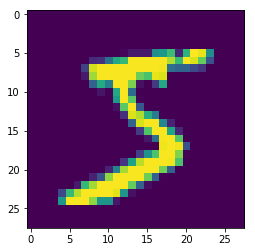

5


In [0]:
!pip install mnist
import mnist
import numpy as np
import matplotlib.pyplot as plt

train_images = mnist.train_images()
train_labels = mnist.train_labels()

example = (train_labels[0], train_images[0])
plt.imshow(example[1])
plt.show()
print(example[0])

## Convolution

First step in a CNN is to apply convolution to the input. Convolution is the process of reducing the complexity of the image and extracting the important features out of the input.

### Filters
A `filter` is used to accomplish this step, a square matrix of values of the same depth as the input is applied onto the image at every pixel (excluding the edges) and its neighbours through element-wise multiplication, with the results summed up, giving the pixel value for the new image. 

For a coloured image,  the filter will generally be a 3d matrix, as coloured images uses RGB channels, with means that they have a depth of 3, or 4 if RGBA. The depth of the filter should always be the same as the depth of the image.

For this project, I'll be using a 3x3x1 matrix, as the inputs are simple black and white images. A typical CNN may have many filters, but since the image set is fairly simple, I'll be using 2 filter layers.

#### Stride

Stride decides how a filter is applied to the image, it is how many steps to skip when moving from 1 pixel to the next when applying the filters, both horizontally and vertially. A stride of more than 1 will reduce the size if the image, so it's useful for large images.

A stride of 1 is called `no stride`, which is what I'll be using for this project as the images are small to begin with, and a larger stride to cause a loss of information.

#### Paddings
After the filter is applied, the resulting image will be smaller than the original image, this is typically not a problem unless the filters are relatively large. Having no padding is call `valid padding`.

If the same image size was to be kept, then a padding of 0s can be added to the edge of the input image, with more paddings added depending on the matrix size, this is called `same padding`.

For this project, I'll be using `valid padding` as there'll likely be no loss of information with losing a few pixels at the border.



### Example of Sobel Filter applied to an image

size of original image: (28, 28)
size of image after convolution: (26, 26)


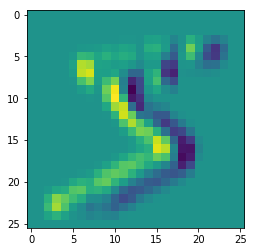

In [0]:
sobel_filter = [
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]

example_h, example_w = example[1].shape
print("size of original image:", example[1].shape)

example_conv = np.zeros((example_h - 2, example_w - 2))

for i in range(example_h - 2): 
  for j in range(example_w - 2):
    example_region = example[1][i:i+3, j:j+3] # taking a 3x3 image region
    
    # applying the filter, summing them, then apply the new value the pixel location
    example_conv[i, j] = np.sum(example_region * sobel_filter)


print("size of image after convolution:", example_conv.shape)
plt.imshow(example_conv)
plt.show()


### Feed Forward

Once the filter is applied, the output image is then feed forward into the next layer, and the input is remembered for later, once the loss is calculated.

### Back Propagation

Because this is the first layer in our neural network, there's nothing further back to pass it to. However, it still takes information regarding the loss gradient of this layer's output and apply it to the filter weight. Because the filter is applied to all pixels of the image, any small change in its weighting changes what the output value is once the filter is applied to the original image. 

The size of the change is determined by the `learning rate`, which scales the changes to a degree that is suitable for the CNN to learn. A smaller learning rate would mean more precision, but also more time spent training, while too large of a learning rate may never reach its target.


### Convolution Code

In [0]:
class Convolution:

  def __init__(self, num_filters, filter_size=None):
    # defaults to a filter size of 3
    if filter_size == None:
      filter_size = 3
    
    self.filter_size = filter_size
    self.num_filters = num_filters

    # filters: 3d array of dimensions (num_filters, filter_size, filter_size)
    # divide by filter_size^2 to reduce the variance of our initial values
    self.filters = \
    np.random.randn(num_filters, filter_size, filter_size) / (filter_size ** 2)

  def iterate_regions(self, image):
    '''
    Generates all possible 3x3 image regions using valid padding.
    - image is a 2d numpy array
    '''
    h, w = image.shape

    for i in range(h - self.filter_size + 1):
      for j in range(w - self.filter_size + 1):
        im_region = image[i:(i + self.filter_size), j:(j + self.filter_size)]
        
        # Using a generator instead of returning an array for memory efficiency
        yield im_region, i, j 

  def forward(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input
    
    h, w = input.shape
    output = \
    np.zeros((h - self.filter_size + 1, w - self.filter_size + 1, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))
    return output
  
  def backprop(self, loss_out, learn_rate):
    '''
    Performs a backward pass of the convolution layer
    loss_out: a 3d numpy array, the loss gradient of this layer's outputs
    learn_rate: percision in the steps to take when learning
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += loss_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    # CNN first layer, does not go back further
    return None

## Pooling

Pooling is the process of downsampling, reducing redundancy in the image pixel information, as neighbouring pixels tends to be of similar values. 

There are generally 3 types of pooling:

- max pooling
- min pooling
- avarage pooling

All these are essentially applying a filter over generally non-overlapping regions. 

In our case, `max pooling` with a 2x2 filter and stride 2, the max value of 2x2 region is taken as assigned as new new pixel value, and then the filter is applied 2 steps away horizontally and veritically until all pixels are pooled.


### Pooling 2x2 with Stride 2 Example

size of original image: (26, 26)
size of image after pooling: (13, 13)


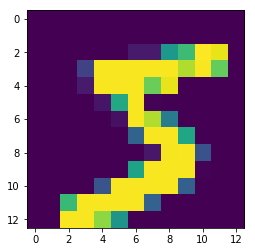

In [0]:
example_h, example_w = example_conv.shape
example_h = example_h // 2
example_w = example_w // 2

print("size of original image:", example_conv.shape)

example_pool = np.zeros((example_h, example_w))

for i in range(example_h): 
  for j in range(example_w):
    # taking a 2x2 image region with stride 2
    example_region = example[1][(2 * i):(2 * i + 2), (2 * j):(2 * j + 2)] 
    
    # get the max value in the array
    example_pool[i, j] = np.amax(example_region)


print("size of image after pooling:", example_pool.shape)
plt.imshow(example_pool)
plt.show()

### Feed Forward

Takes the input from the convolution layer and applies 2x2 max pooling on each non-overlapping image region, resulting in halving the size of the image, but the same depth.

### Back Propagation

Max pooling actually does not use any weights as it directly takes the max values of each region, however, it is still necessary to assign the loss gradient to where the orginal max value was so that it can be used by the convolutional layer.

### Pooling Code

In [0]:
class Pooling:
  # A Max Pooling layer using a pool size of 2

  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 2d numpy array
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j
  
  def forward(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    self.last_input = input
      
    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))
    return output

  def backprop(self, d_L_d_out):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]
    
    return d_L_d_input


## Fully Connected Layer

The fully connected layer takes the output from the pooling layer and produces a vector of N size, where N is the number of classes. Each value in the vector represents the probability of of the input being of that class.

The class with the highest probability is chosen as the final prediction, but having the probability value for the actual correct class allows us to better calculate loss. 

There are many ways to calculate loss, two most notable being Mean Squared Error (MSE) and Cross-Entropy loss. Cross-Entropy is overall better performing for CNNs, being a more punishing loss calculation, which is what I'll be using.

### Cross-Entropy Loss

Cross-entropy loss is also known as log loss. It measures the performance of probability values between 0-1. The loss increases exponentially the lower the correct prediction is. This is a crucial step in letting the CNN understand what it did wrong and how much it is wrong by, using the current weights.

It's calculated by `L=-ln(p)`, where `L` is loss, and `p` is predicted probability of the correct class.


### Softmax Activation Function

Softmax is a function that converts a vector of values into to the range of 0-1, with the sum adding up to one, which allows to calculate for the cross entropy loss of the predictions

It does so by raising each value(`i`) in the vector in `e^i`, using that as the numerator, and then using the sum of `e^i` for all values in the vector as the demoniator.

### Softmax Example with Loss

This is akin to random guessing as the weights are not properly trained, and there are no biases towards any value based on training.

In [0]:
example_softmax = example_pool.flatten() # flattened as the extra dimentionality are not useful

# 10 classes, one for each digit
example_weights = np.random.randn(example_softmax.size, 10) / example_softmax.size 

example_totals = np.dot(example_softmax, example_weights)

# raise all values by exponential
example_exp = np.exp(example_totals)
# divide each individual value in respect to sum
example_classification = example_exp / np.sum(example_exp)

np.set_printoptions(precision=3, suppress=True)
print("vector of predictions:\n", example_classification)

np.set_printoptions(precision=None, suppress=False)
print("prediction:", np.argmax(example_classification))
print("actual:", example[0])

# L = -log(p)
example_loss = -np.log(example_classification[example[0]]) 
print("loss:", example_loss)

vector of predictions:
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
prediction: 6
actual: 5
loss: 18.7156095927266


### Feed Forward

The input is flattened, and a value is assigned to each of the 10 classes based on the weights and biases. The prediction is scaled by softmax activation and the result is returned.

### Back Propagation

A vector is passed into function with only theintial gradient for predictions for the correct class containing the value of the softmax outputs. 

The loss gradient is then calculated for all other classes through taking the derivative of the correct class prediction over the the respective classes with the equation `-e^t_c * -e^t_k / S^2`, where `e^t_c` is the exponential for the correct class, and `e^t_k`is the exponential for the incorrect classes, and S is the sum of the exponentials.

The loss gradient for the correct class is gotten through `e^t_c * (S - e^t_c) / S^2`, with the same variables as above.

After getting the loss gradient for each prediction, they are then used to calculate the following:

- weight graidnet, `d_L/d_w`
- biases gradient, `d_L/d_b`
- input gradient, `d_L/d_input`

the weight gradients and biases gradients are used to update the softmax activation's values, while the input gradient is passed alone into the pooling layer for further breakdown.

### Softmax Activation Code

In [0]:
class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape
    
    input = input.flatten()
    self.last_input = input
    input_len, nodes = self.weights.shape

    # Makes prediction
    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals
    
    # Scales prediction by e^totals
    exp = np.exp(totals)
    # e^totals / sum(e^totals)
    return exp / np.sum(exp, axis=0)
  
  def backprop(self, d_L_d_out, learn_rate):    
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float    
    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases      
      self.weights -= learn_rate * d_L_d_w      
      self.biases -= learn_rate * d_L_d_b       
      return d_L_d_inputs.reshape(self.last_input_shape)

## Training

Training is arguably the most crucial part as it ties everything together, and teaches the CNN on what to look for and what values to have in the filters and weights.

The training process is done through `back propagation`, where the loss is calculated for the predictions and passed back through each layer for them to readjust their weight values towards better accuracy. 

The more accurate their predictions are, the less they would have to adjust in value, due to the nature of Cross-Entropy loss.

The training is done in 3 `epochs`, which means 3 forward pass and backwards pass of all the examples. With each epoch containing a thousand training samples.

### Training Code

In [0]:
# Using the first thousand for demonstration
train_images = mnist.train_images()[:1000]
train_labels = mnist.train_labels()[:1000]
test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

num_filters = 3

conv = Convolution(num_filters)                  # 28x28x1 -> 26x26x8
pool = Pooling()                  # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * num_filters, 10) # 13x13x8 -> 10

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc


# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i > 0 and i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.274 | Accuracy: 12%
[Step 200] Past 100 steps: Average Loss 2.198 | Accuracy: 22%
[Step 300] Past 100 steps: Average Loss 2.009 | Accuracy: 34%
[Step 400] Past 100 steps: Average Loss 1.458 | Accuracy: 59%
[Step 500] Past 100 steps: Average Loss 1.172 | Accuracy: 62%
[Step 600] Past 100 steps: Average Loss 0.839 | Accuracy: 77%
[Step 700] Past 100 steps: Average Loss 0.748 | Accuracy: 77%
[Step 800] Past 100 steps: Average Loss 0.632 | Accuracy: 77%
[Step 900] Past 100 steps: Average Loss 0.684 | Accuracy: 77%
[Step 1000] Past 100 steps: Average Loss 0.879 | Accuracy: 71%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 0.561 | Accuracy: 83%
[Step 200] Past 100 steps: Average Loss 0.586 | Accuracy: 77%
[Step 300] Past 100 steps: Average Loss 0.655 | Accuracy: 82%
[Step 400] Past 100 steps: Average Loss 0.470 | Accuracy: 83%
[Step 500] Past 100 steps: Average Loss 0.577 | Accuracy: 82%
[Step 600] Past 100 steps: Average Lo

In [0]:
# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
Test Loss: 0.524555431820456
Test Accuracy: 0.83


In [0]:
pred, l, acc = forward(example[1], example[0])

print("predicted:", np.argmax(pred))
print("actual:", example[0])

predicted: 5
actual: 5


# Summary

Although the CNN does not produce the most accurate result, and there's still a lot to improve on, the success of this CNN implementation is undeniable. With an accuracy of around 90%, the prediction has a lot to improve still, but even so, it works well enough for its intended purpose.

Some improvements could be made with the structure of the CNN, possibly following AlexNet structure or LeNet would prove to produce better results, or perhaps simply adding more layers would improve the results.

# Social and Ethical Complications

General applications of a Convolutional Neural Network is in the genre related to image classification, this can also include object detection, facial recognition and so on. 

There's a lot of good that it can do and has done for society so far, with one example being Optical Character Recognition (OCR), which is not too different from what this project does. OCR has significantly improved with CNNs and allows for much simplier and streamlined process for processing handwritten documents. 

CNN's application in medical imaging is very notable, as a well trained CNN algorithm is able to classify imagings containing signs of lung disease (Q. Li et al. 2014), with different applications of the algorithms being able achieve many things for the medical field.

However, with advancement of technology comes abuse of said technology. CNN's potential for misuse is quite high. Just recently there's 2 apps developed using Generative Adversarial Networks (GANs) called DeepFake and DeepNude. Both applications allows the user to unconcentially replace the image of someone with something different, while keeping certain recognisable characteristics, with DeepNude being more malicious in its design than DeepFake. Both applications, although not directly utilising CNNs, demonstrates the possible misuse in image classification techniques such as CNN. This is not to mention the possibilities of using facial recognition implemented with CNN for unconsential monitoring of other.

Algorithms like CNN ultimately does more good in making people easier and potentially saving people's lives. But when implementing such algorithms, it's imperitive to review your intentions, following the Kantian ideal of ethics. 

# References

Q. Li, W. Cai, X. Wang, Y. Zhou, D. D. Feng and M. Chen, "Medical image classification with convolutional neural network," *2014 13th International Conference on Control Automation Robotics & Vision (ICARCV)*, Singapore, 2014, pp. 844-848.

Zhou, V. (2019). CNNs, Part 1: An Introduction to Convolutional Neural Networks. [online] Victorzhou.com. Available at: *https://victorzhou.com/blog/intro-to-cnns-part-1/*

# Links

Github:
https://github.com/AmethystProductions/UTS_ML_2019/blob/master/Assignment_2_CNN.ipynb

Youtube:
https://youtu.be/BI0gjb2KKWM